In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
import numpy as np
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

data = pd.read_csv(r"C:\Users\alpie\social-graphs-dtu\Project\archive\employee_reviews.csv", low_memory=False)

In [2]:
data.head()

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


In [3]:
companies = data['company'].unique()
print("Unique values in 'type' column:", companies)

Unique values in 'type' column: ['google' 'amazon' 'facebook' 'netflix' 'apple' 'microsoft']


In [4]:
job_title = data['job-title'].unique()
print("Unique values in 'type' column:", job_title)

Unique values in 'type' column: ['Current Employee - Anonymous Employee'
 'Former Employee - Program Manager'
 'Current Employee - Software Engineer III' ...
 'Current Employee - Programmer Manager'
 'Former Employee - Senior Project Managet'
 'Current Employee - Technical Sales Manager']


In [5]:
relevant_columns = ['company', 'dates', 'job-title', 'summary', 'pros', 'cons', 'advice-to-mgmt', 'overall-ratings']
filtered_data = data[relevant_columns]

In [ ]:
#Ensure datetime format
filtered_data['dates'] = pd.to_datetime(filtered_data['dates'], errors='coerce')

C:\Users\alpie\AppData\Local\Temp\ipykernel_3368\2177077318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['dates'] = pd.to_datetime(filtered_data['dates'], errors='coerce')


In [7]:
filtered_data = filtered_data.dropna(subset=['dates', 'overall-ratings'])

In [8]:
#Categorize data into pre-2016 and 2016-onwards
filtered_data['date_category'] = filtered_data['dates'].apply(lambda x: 'Pre-2016' if x.year < 2016 else '2016+')

In [ ]:
#Group by company and date category, calculating the average rating
grouped_data = filtered_data.groupby(['company', 'date_category'])['overall-ratings'].mean().reset_index()

In [10]:
print("Average Overall Ratings Per Company Per Date Category:")
print(grouped_data)

Average Overall Ratings Per Company Per Date Category:
      company date_category  overall-ratings
0      amazon         2016+         3.675033
1      amazon      Pre-2016         3.333333
2       apple         2016+         3.987489
3       apple      Pre-2016         3.925103
4    facebook         2016+         4.461538
5    facebook      Pre-2016         4.575071
6      google         2016+         4.409351
7      google      Pre-2016         4.258616
8   microsoft         2016+         4.013188
9   microsoft      Pre-2016         3.679811
10    netflix         2016+         3.574830
11    netflix      Pre-2016         3.316505


In [11]:
grouped_data = filtered_data.groupby(['company', 'date_category'])['overall-ratings'].mean().reset_index()

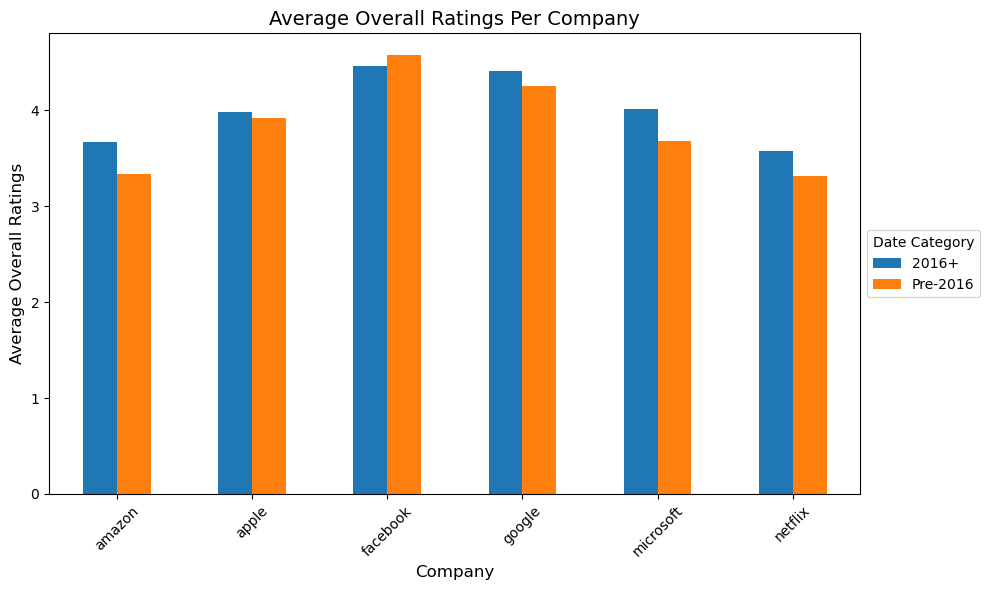

In [12]:
pivot_data = grouped_data.pivot(index='company', columns='date_category', values='overall-ratings')
pivot_data.plot(kind='bar', figsize=(10, 6))

plt.title("Average Overall Ratings Per Company", fontsize=14)
plt.xlabel("Company", fontsize=12)
plt.ylabel("Average Overall Ratings", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Date Category", loc='center left', bbox_to_anchor=(1.0, 0.5))  # Legend to the right
plt.tight_layout()
plt.show()

In [13]:
filtered_data['employee_status'] = filtered_data['job-title'].apply(lambda x: str(x).split(' ')[0])
filtered_data['job_pos'] = filtered_data['job-title'].apply(lambda x: str(x).split(' - ')[1])
count_data = filtered_data.groupby(['company', 'employee_status']).size().reset_index(name='count')

In [14]:
Jobs = filtered_data['job_pos'].unique()
print(Jobs)

['Anonymous Employee' 'Program Manager' 'Software Engineer III' ...
 'Lead Quality Engineer' 'Senior Project Managet'
 'Technical Sales Manager']


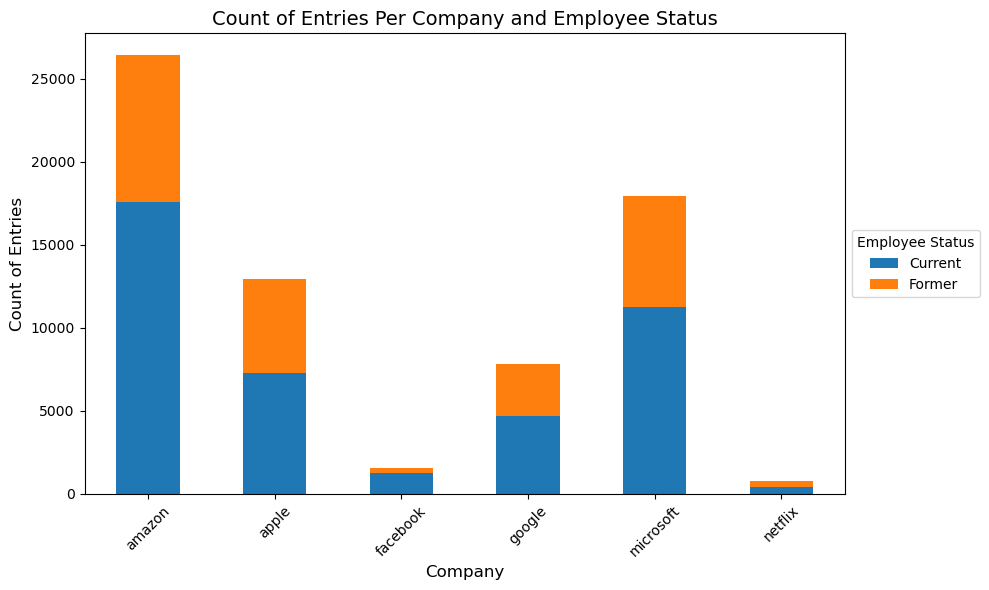

In [15]:
pivot_count_data = count_data.pivot(index='company', columns='employee_status', values='count')
pivot_count_data.plot(kind='bar', figsize=(10, 6), stacked=True)

plt.title("Count of Entries Per Company and Employee Status", fontsize=14)
plt.xlabel("Company", fontsize=12)
plt.ylabel("Count of Entries", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Employee Status", loc='center left', bbox_to_anchor=(1.0, 0.5))  # Legend to the right
plt.tight_layout()
plt.show()

In [16]:
columns_to_merge = ['summary', 'pros', 'cons', 'advice-to-mgmt']
filtered_data[columns_to_merge] = filtered_data[columns_to_merge].fillna("").astype(str)

In [17]:
filtered_data['feedback'] = filtered_data[columns_to_merge].apply(
    lambda row: '. '.join(filter(None, row)), axis=1
)

In [18]:
print(filtered_data[['company', 'employee_status', 'feedback']].head(20))

   company employee_status                                           feedback
0   google         Current  Best Company to work for. People are smart and...
1   google          Former  Moving at the speed of light, burn out is inev...
2   google         Current  Great balance between big-company security and...
3   google         Current  The best place I've worked and also the most d...
4   google          Former  Unique, one of a kind dream job. Google is a w...
5   google          Former  NICE working in GOOGLE as an INTERN. People ar...
6   google         Current  Software engineer. Great working environment. ...
7   google          Former  great place to work and progress. work culture...
8   google         Current  Google Surpasses Realistic Expectations. Great...
9   google         Current  Execellent for engineers. Impact driven. Best ...
10  google         Current  Nice place to work. * Smart people * World cla...
11  google         Current  Software Engineer. * There is endles

In [19]:
labmt_df = pd.read_csv("C:\\Users\\alpie\\OneDrive\\Desktop\\Coding\\SocialGraphs\\DataSet.csv", delimiter=";")

In [20]:
happiness_dict = dict(zip(labmt_df['word'], labmt_df['happiness_average']))

In [21]:
def calculate_sentiment(tokens):
    sentiment = 0
    for token in tokens:
        if token in happiness_dict:
            sentiment += happiness_dict[token]

    return round(sentiment, 2)

In [ ]:
#Download required NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alpie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alpie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alpie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Sentiment calculation function
def calculate_sentiment(tokens):
    sentiment = 0
    for token in tokens:
        if token in happiness_dict:
            sentiment += happiness_dict[token]
    return round(sentiment, 2)

In [24]:
lemmatizer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
quotes = ['``', "''", '’', '""', '“', '”']

In [ ]:
#Calculate sentiment for the feedback grouped by each company
feedback_sentiment = {}

for company, feedbacks in filtered_data.groupby('company')['feedback']:
    combined_feedback = " ".join(feedbacks).lower()
    tokens = word_tokenize(combined_feedback)
    tokens = [word.lower() for word in tokens if word not in string.punctuation]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]
    tokens = [word for word in tokens if len(word) > 1 and word not in quotes]
    sentiment_score = calculate_sentiment(tokens)
    feedback_sentiment[company] = round(sentiment_score, 4)

#Display sentiment scores for each company
feedback_sentiment


{'amazon': 5263434.02,
 'apple': 2714677.69,
 'facebook': 393217.19,
 'google': 1330453.81,
 'microsoft': 3705520.73,
 'netflix': 256961.06}

In [26]:
sentiment_values = list(feedback_sentiment.values())

avg_sentiment = np.mean(sentiment_values)
median_sentiment = np.median(sentiment_values)
variance_sentiment = np.var(sentiment_values)
percentile_25 = np.percentile(sentiment_values, 25)
percentile_75 = np.percentile(sentiment_values, 75)


In [27]:
print(f"Average sentiment: {avg_sentiment:.2f}")
print(f"Median sentiment: {median_sentiment:.2f}")
print(f"Variance sentiment: {variance_sentiment:.2f}")
print(f"25th percentile: {percentile_25:.2f}")
print(f"75th percentile: {percentile_75:.2f}")

Average sentiment: 2277377.42
Median sentiment: 2022565.75
Variance sentiment: 3279360870281.35
25th percentile: 627526.34
75th percentile: 3457809.97


In [28]:
def calculate_feedback_happiness(feedback):
    tokens = word_tokenize(feedback.lower())
    tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]
    tokens = [word for word in tokens if len(word) > 1 and word not in quotes]
    sentiment = sum(happiness_dict.get(token, 0) for token in tokens)
    return sentiment / len(tokens) if tokens else 0

In [38]:
#Happiness average to each feedback
filtered_data['happiness_average'] = filtered_data['feedback'].apply(calculate_feedback_happiness)

#Group by company, date category, and employee status
average_happiness = filtered_data.groupby(['company', 'date_category', 'employee_status'])['happiness_average'].mean().reset_index()

In [39]:
average_happiness.rename(columns={'happiness_average': 'average_happiness'}, inplace=True)
average_happiness.head(10)

,company,date_category,employee_status,average_happiness
0,amazon,2016+,Current,4.896243
1,amazon,2016+,Former,4.815525
2,amazon,Pre-2016,Current,4.895031
3,amazon,Pre-2016,Former,4.828620
4,apple,2016+,Current,5.015258
5,apple,2016+,Former,4.977065
6,apple,Pre-2016,Current,5.056469
7,apple,Pre-2016,Former,5.030091
8,facebook,2016+,Current,4.994634
9,facebook,2016+,Former,4.870865


In [30]:
pivot_happiness = average_happiness.pivot_table(
    index='company',
    columns=['date_category', 'employee_status'],
    values='average_happiness'
)

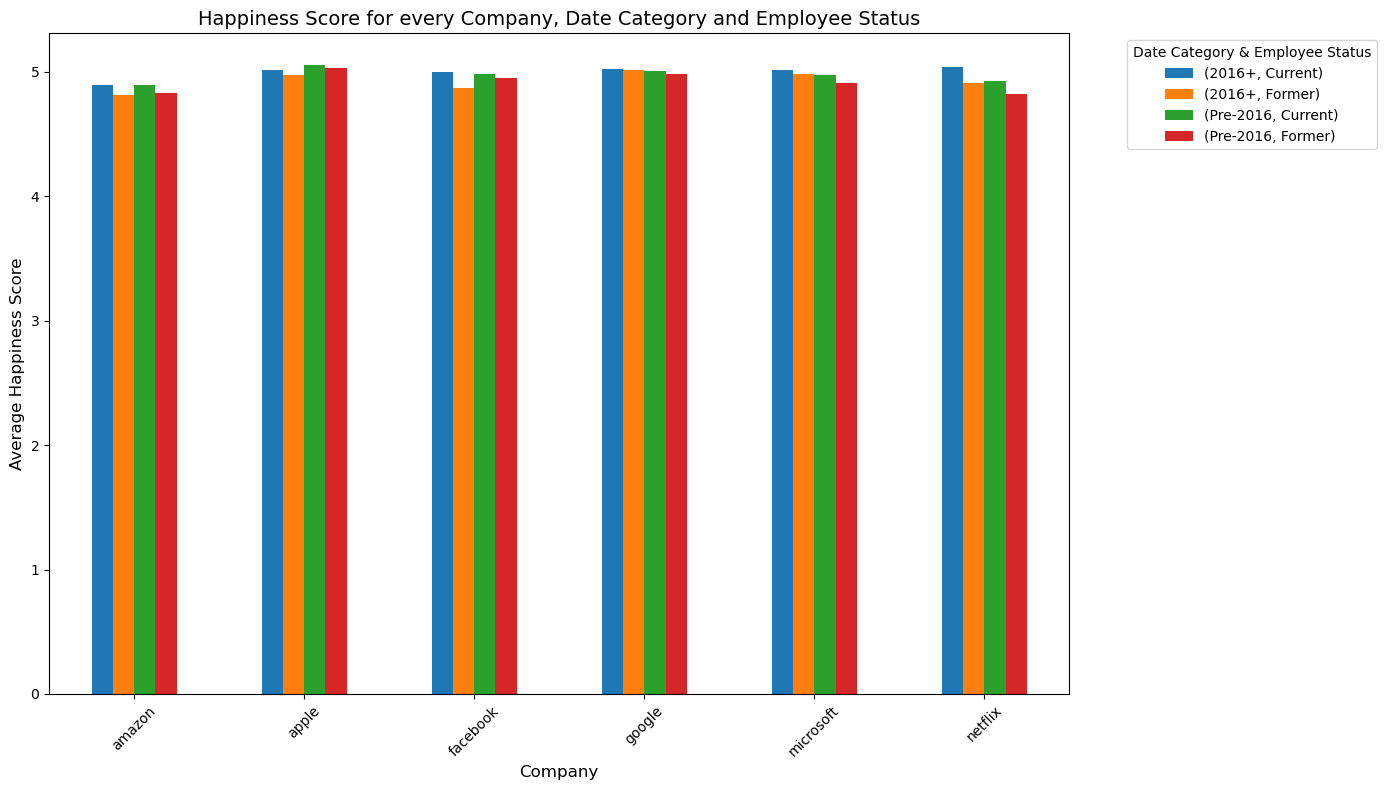

In [ ]:
pivot_happiness.plot(kind='bar', figsize=(14, 8))
plt.title("Happiness Score for every Company, by Date and Employee Status", fontsize=14)
plt.xlabel("Company", fontsize=12)
plt.ylabel("Average Happiness Score", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Date Category & Employee Status", loc='upper left', bbox_to_anchor=(1.05, 1.0))  # Legend to the right
plt.tight_layout()
plt.show()

#### **Calculate and visualize TF-IDFs.**

In [ ]:
#Group feedback by company or other categories
grouped_feedback = filtered_data.groupby('company')['feedback'].apply(' '.join).reset_index()

In [ ]:
#TF-IDF Vectors
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = vectorizer.fit_transform(grouped_feedback['feedback'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=grouped_feedback['company'])

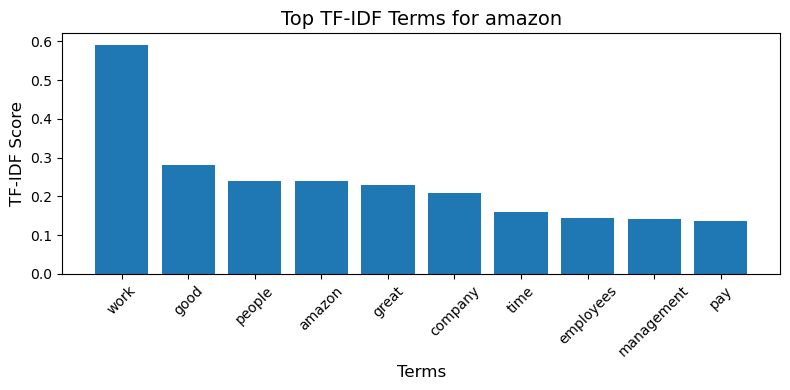

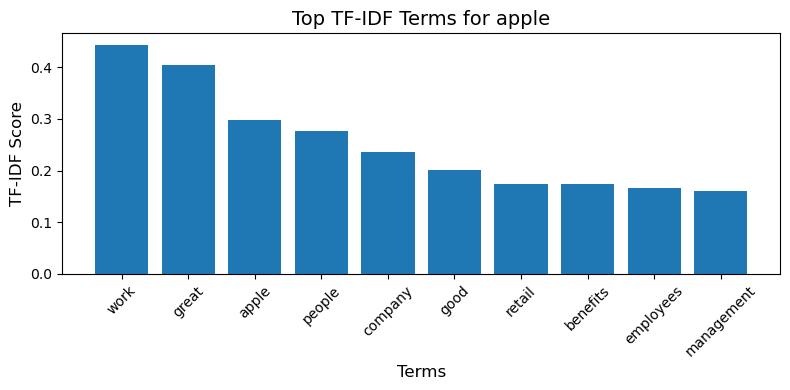

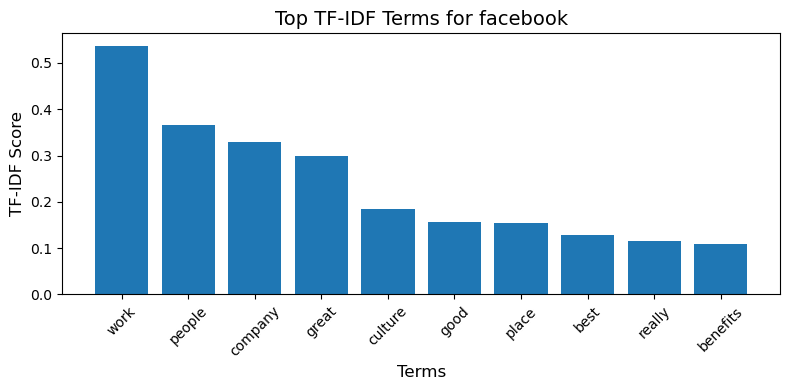

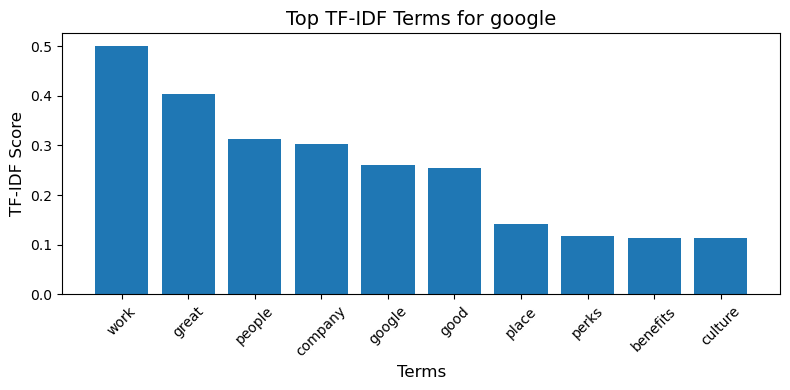

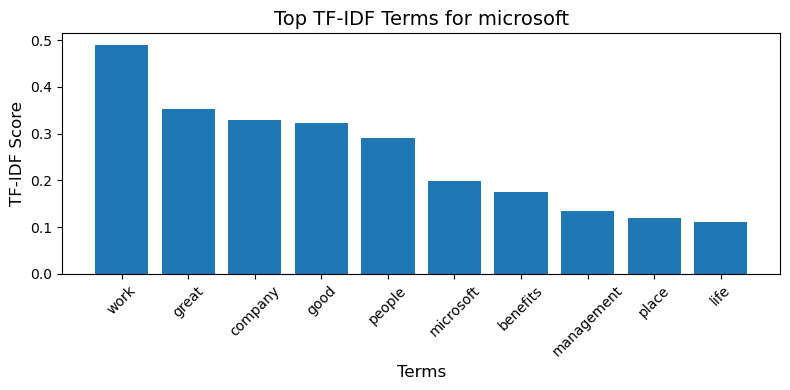

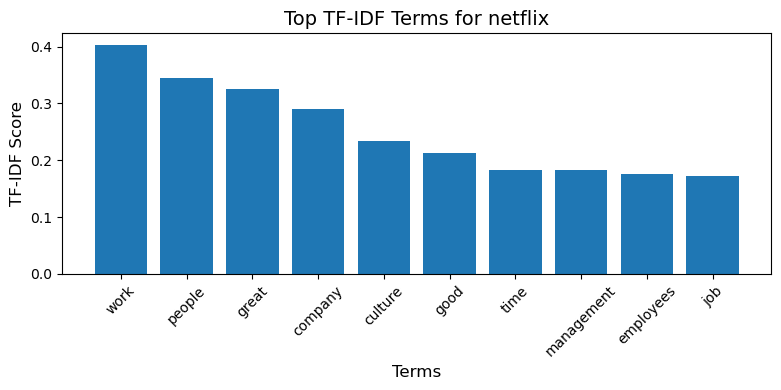

In [36]:
for company in tfidf_df.index:
    top_terms = tfidf_df.loc[company].sort_values(ascending=False).head(10)
    plt.figure(figsize=(8, 4))
    plt.bar(top_terms.index, top_terms.values)
    plt.title(f"Top TF-IDF Terms for {company}", fontsize=14)
    plt.xlabel("Terms", fontsize=12)
    plt.ylabel("TF-IDF Score", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

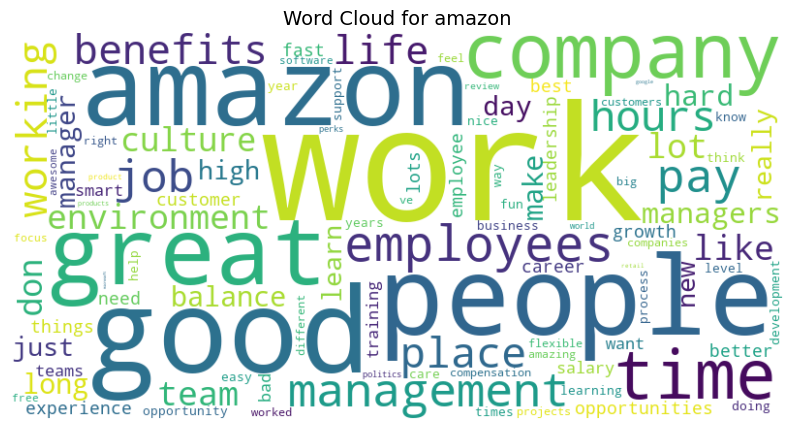

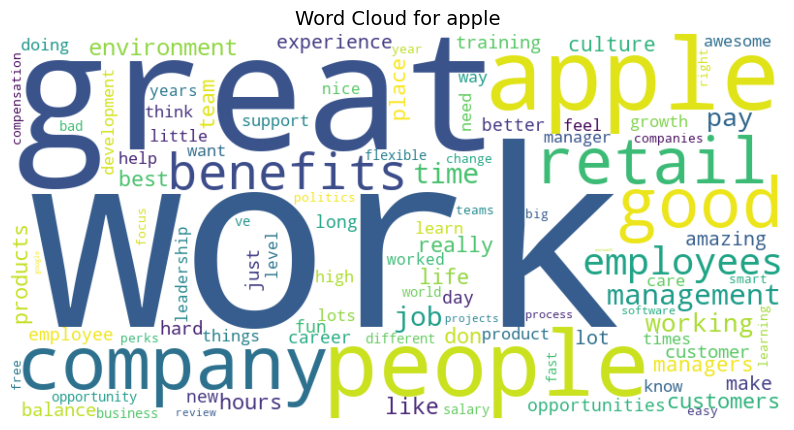

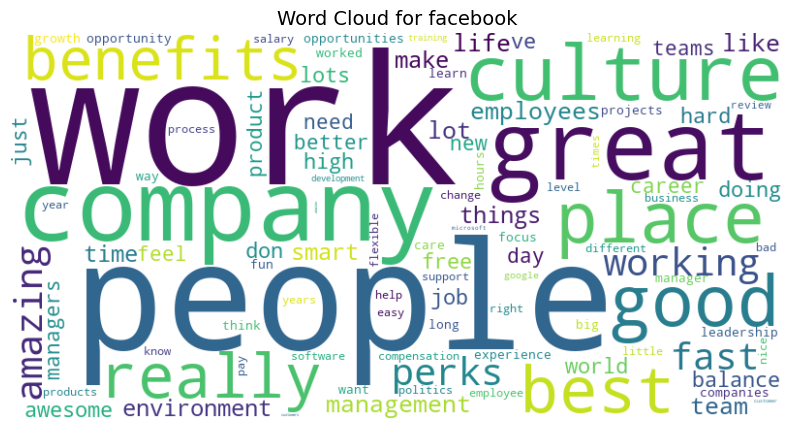

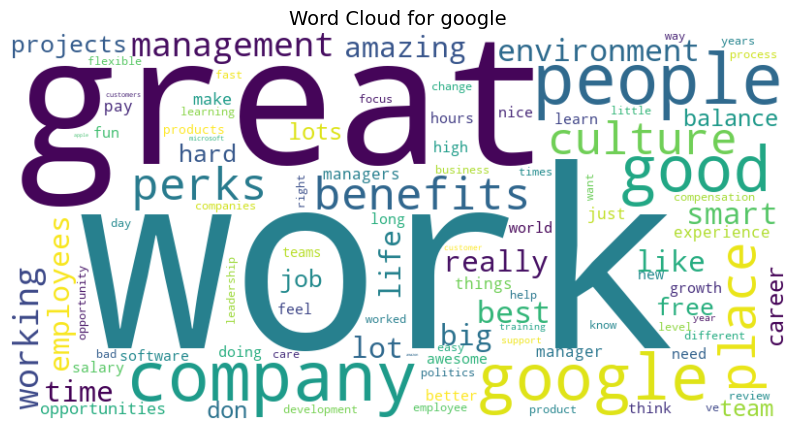

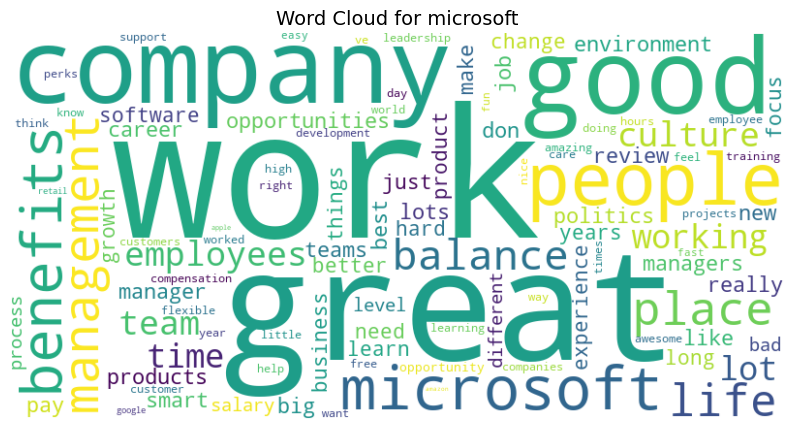

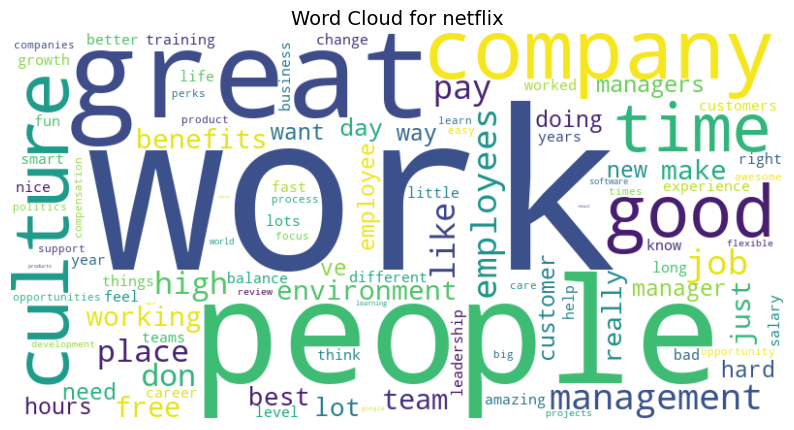

In [37]:
#Word Cloud for Each Company
for company in tfidf_df.index:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
        tfidf_df.loc[company].to_dict()
    )
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {company}", fontsize=14)
    plt.show()